# Inference Drift Analysis on Squeezenet Neural Network using IBM Analog Hardware Accelerator Kit.

Evaluating Inference Drift on analog Squeezenet for the Visual Wake Words Dataset by sweeping over RPU configurations. 



# Analog AI

**Related publications: https://researcher.watson.ibm.com/researcher/view_group.php?id=7716**

One of the biggest challenges in current Neural Networks is the energy consumption. Conventional computers perform calculations by transferring data between memory and processor, which takes time and energy. By leveraging the physical properties of the in-memory computing devices that Analog AI offers, computation happens at the same place where the data is stored, which in turn reduces energy consumption drastically.This allows us to have the speed and energy-efficiency required to move AI forward.

When performing inference in deep learning, data propagation through multiple layers of a neural network involves a sequence of matrix multiplications and each of these layers can be represented as a matrix of synaptic weights. On an Analog chip, these weights are stored in the conductance states of resistive devices such as PCM. Because there is no movement of data, tasks can be performed in a fraction of the time and with much less energy. Moreover, these devices do not consume power when inactive, and the data will be retained for up to 10 years even when the power supply is turned off.

# IBM Analog Hardware Acceleration Kit

**Github Repository: https://github.com/IBM/aihwkit**

IBM Analog Hardware Acceleration Kit is an open source Python toolkit for exploring and using the capabilities of in-memory computing devices in the context of artificial intelligence.

It contains a PyTorch integration that include Analog neural network modules (fully connected layer, 1d/2d/3d convolution layers, sequential container), Analog training using torch training workflow and Analog inference using torch inference workflow.

# Squeezenet 

**Original Paper: https://arxiv.org/abs/1602.07360**

SqueezeNet is a deep neural network for computer vision developed by researchers at DeepScale, University of California, Berkeley, and Stanford University and released in 2016. This smaller neural network has AlexNet-level accuracy with 50x fewer parameters and  a 0.5MB model size, which enables it to easily fit into computer memory. 

For this study, PyTorch's implementation was used. There are two options: squeezenet1_0 based on the original paper and squeezenet1_1 from the [official squeezenet repo](https://github.com/forresti/SqueezeNet/tree/master/SqueezeNet_v1.1) which has 2.4x less computation and slightly fewer parameters than squeezenet1_0, without sacrificing accuracy.

# Visual Wake Words

**Original paper: https://arxiv.org/abs/1906.05721**

This Dataset is an adaptation of COCO Dataset proposed by Google to address the fact that other common image datasets are not representative of the typical microcontroller vision use-cases. It serves as a benchmark for the tiny vision models to deploy on microcontrollers and advance research in this area. 

They selected the use-case of classifying images of two classes, by labeling whether a person is present in the image or not. This dataset repurposes the
publicly available COCO dataset into a dataset of 115k training and validation images with labels of person and not-person.


# Import requirements

In [ ]:
%matplotlib inline
import sys
sys.path.append("/home/pierre/aihwkit/src")

In [ ]:
from pathlib import Path
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
from torch import nn, device, manual_seed, no_grad, cuda, optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ExponentialLR

from datetime import datetime
import numpy as np

import torchvision.transforms as T
from torchvision import models

from torchinfo import summary

import matplotlib.pyplot as plt
import pyvww

import wandb

## Data Preprocessing for Visual Wake Words

In [ ]:
preprocess = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

dataset_path = "data/visualwakewords/"
train_dataset = pyvww.pytorch.VisualWakeWordsClassification(root=dataset_path + "/path-to-COCO-dataset/all2014", annFile=dataset_path + "new-path-to-visualwakewords-dataset/annotations/instances_train.json", transform=preprocess)
val_dataset = pyvww.pytorch.VisualWakeWordsClassification(root=dataset_path + "/path-to-COCO-dataset/all2014", annFile=dataset_path + "new-path-to-visualwakewords-dataset/annotations/instances_val.json", transform=preprocess)

loading annotations into memory...
Done (t=3.82s)
creating index...
index created!
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!


## Build Digital Squeezenet Model

We begin by defining a conventional "digital" Squeezenet network on the Visual Wake Words task, which will act as the accuracy baseline for our experiments.

In [ ]:
model = torch.load("small_squeezenet_0.63.pt")
for param in model.parameters():
    param.requires_grad = True
print(summary(model, input_size=train_dataset[0][0].unsqueeze(0).shape))

Layer (type:depth-idx)                   Output Shape              Param #
SqueezeNet                               [1, 1]                    --
├─Sequential: 1-1                        [1, 256, 13, 13]          --
│    └─Conv2d: 2-1                       [1, 64, 111, 111]         1,792
│    └─ReLU: 2-2                         [1, 64, 111, 111]         --
│    └─MaxPool2d: 2-3                    [1, 64, 55, 55]           --
│    └─Fire: 2-4                         [1, 128, 55, 55]          --
│    │    └─Conv2d: 3-1                  [1, 16, 55, 55]           1,040
│    │    └─ReLU: 3-2                    [1, 16, 55, 55]           --
│    │    └─Conv2d: 3-3                  [1, 64, 55, 55]           1,088
│    │    └─ReLU: 3-4                    [1, 64, 55, 55]           --
│    │    └─Conv2d: 3-5                  [1, 64, 55, 55]           9,280
│    │    └─ReLU: 3-6                    [1, 64, 55, 55]           --
│    └─Fire: 2-5                         [1, 128, 55, 55]          --
│  

In [ ]:
    def create_model_digital():
    squeezenet = models.squeezenet1_1(weights=models.SqueezeNet1_1_Weights.IMAGENET1K_V1)
    features = list(squeezenet.features.children())
    squeezenet.classifier = nn.Sequential(
        nn.Dropout(0.5, inplace=False),
        nn.Flatten(),
        nn.BatchNorm1d(256*13*13),
        nn.Linear(256*13*13,1),
        nn.Sigmoid(),
    )
    squeezenet.features = nn.Sequential(*features[:-4])
    def init_weights(m):
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    squeezenet.classifier.apply(init_weights)
    return squeezenet

# RPU configurations

**Original documentation: https://aihwkit.readthedocs.io/en/latest/using_simulator.html#rpu-configurations**

The basic component involved in a simulation is known as Analog Tile, this is a two-dimensional array of resistive devices that determine its behavior and properties. AIHWKIT's analog layers utilize the rpu_config input which defines various settings of the RPU tile or the Analog hardware. Here the user can specify hardware specs such as bits used by the ADC/DAC converters, noise values, devices, etc.

For this project, we created an ideal RPU configuration based on the following example code snippet: https://github.com/HCY-11/aihwkit/blob/bert_example_hy/examples/24_bert_on_squad.py. And a secondary rpu configuration used to sweep over the parameters.

In [ ]:
from aihwkit.simulator.configs import InferenceRPUConfig
from aihwkit.simulator.configs.utils import WeightClipType, WeightNoiseType, BoundManagementType
from aihwkit.simulator.presets.utils import PresetIOParameters
from aihwkit.inference import PCMLikeNoiseModel, GlobalDriftCompensation
from aihwkit.nn.conversion import convert_to_analog
from aihwkit.nn.modules.container import AnalogSequential
from aihwkit.optim import AnalogSGD


def create_ideal_rpu_config(g_max=160, dac_res=256, adc_res=256, tile_size=256, w_noise=0.0, out_noise=0.0):
    rpu_config = InferenceRPUConfig()
    rpu_config.modifier
    rpu_config.clip.type = WeightClipType.FIXED_VALUE
    rpu_config.clip.fixed_value = 1.0
    rpu_config.modifier.rel_to_actual_wmax = True
    rpu_config.mapping.digital_bias = True
    rpu_config.mapping.learn_out_scaling_alpha = True
    rpu_config.mapping.weight_scaling_omega = 1
    rpu_config.mapping.weight_scaling_omega_columnwise = True
    rpu_config.mapping.max_input_size = tile_size
    rpu_config.mapping.max_output_size = 255
    rpu_config.forward = PresetIOParameters()
    rpu_config.forward.w_noise_type = WeightNoiseType.PCM_READ
    rpu_config.forward.w_noise = w_noise
    rpu_config.forward.out_noise = out_noise
    rpu_config.forward.inp_res = -1
    rpu_config.forward.out_res = -1
    rpu_config.forward.bound_management = BoundManagementType.ITERATIVE
    rpu_config.noise_model = PCMLikeNoiseModel(g_max=g_max, prog_noise_scale=0, read_noise_scale=0)
    rpu_config.drift_compensation = GlobalDriftCompensation()
    return rpu_config

def create_rpu_config(g_max=160, tile_size=256, dac_res=256, adc_res=256, w_noise=0.0175):
    rpu_config = InferenceRPUConfig()
    rpu_config.clip.type = WeightClipType.FIXED_VALUE
    rpu_config.clip.fixed_value = 1.0
    rpu_config.modifier.rel_to_actual_wmax = True
    rpu_config.mapping.digital_bias = True
    rpu_config.mapping.learn_out_scaling_alpha = True
    rpu_config.mapping.weight_scaling_omega = 1
    rpu_config.mapping.weight_scaling_omega_columnwise = True
    rpu_config.mapping.max_input_size = tile_size
    rpu_config.mapping.max_output_size = 255
    rpu_config.forward = PresetIOParameters()
    rpu_config.forward.w_noise_type = WeightNoiseType.PCM_READ
    rpu_config.forward.w_noise = w_noise
    rpu_config.forward.inp_res = 1/dac_res
    rpu_config.forward.out_res = 1/adc_res
    rpu_config.forward.bound_management = BoundManagementType.ITERATIVE
    rpu_config.noise_model = PCMLikeNoiseModel(g_max=g_max)
    rpu_config.drift_compensation = GlobalDriftCompensation()
    return rpu_config

def create_model_analog(squeezenet, rpu_config):
    model = nn.Sequential(*list(squeezenet.children()))
    model = convert_to_analog(model, rpu_config, realistic_read_write=False)
    return model

# Digital Squeezenet Pre training

In [ ]:
# Tools for digital and analog training and evaluation.
# This code mainly originates from one of the Aihwkit examples.
# https://github.com/IBM/aihwkit/blob/master/examples/06_lenet5_hardware_aware.py 

# The reused code is under the following license:
# (C) Copyright 2020, 2021, 2022 IBM. All Rights Reserved.
#
# This code is licensed under the Apache License, Version 2.0. You may
# obtain a copy of this license in the LICENSE.txt file in the root directory
# of this source tree or at http://www.apache.org/licenses/LICENSE-2.0.
#
# Any modifications or derivative works of this code must retain this
# copyright notice, and modified files need to carry a notice indicating
# that they have been altered from the originals.


def create_data_loaders(batch_size, num_workers, prefetch_factor=2):
    train_data = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=USE_CUDA, prefetch_factor=prefetch_factor)
    val_data = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=USE_CUDA, prefetch_factor=prefetch_factor)
    return train_data, val_data


@no_grad()
def test_evaluation(data, model, criterion):
    """Test trained network
    Args:
        data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
    Returns:
        float, float, float: test epoch loss, test error, and test accuracy
    """
    total_loss = 0
    predicted_ok = 0
    total_images = 0
    fasle_positive = 0
    false_negative = 0
    true_positive = 0

    model.eval()

    for images, labels in tqdm(data, total = len(data), desc = "Evaluation"):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE).float()

        pred = model(images).squeeze(dim=1)
        loss = criterion(pred, labels)
        total_loss += loss.item() * images.size(0)

        detection = pred > 0.5
        labels = labels > 0.5
        total_images += labels.size(0)
        predicted_ok += (detection == labels).sum().item()
        fasle_positive += torch.logical_and(detection, torch.logical_not(labels)).sum().item()
        false_negative += torch.logical_and(torch.logical_not(detection), labels).sum().item()
        true_positive += torch.logical_and(detection, labels).sum().item()

    accuracy = predicted_ok/total_images*100
    f1_score = true_positive / (true_positive + 0.5 * false_negative + 0.5 * fasle_positive) *100
    epoch_loss = total_loss / len(data.dataset)

    return epoch_loss, f1_score, accuracy


def create_sgd_optimizer(model, learning_rate):
    """Create the analog-aware optimizer.
    Args:
        model (nn.Module): model to be trained
        learning_rate (float): global parameter to define learning rate
    Returns:
        Optimizer: created analog optimizer
    """
    optimizer = AnalogSGD(model.parameters(), lr=learning_rate)
    optimizer.regroup_param_groups(model)
    return optimizer


def train_step(data, model, criterion, optimizer, scheduler):
    """Train network.
    Args:
        data (DataLoader): Validation set to perform the evaluation
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
        optimizer (Optimizer): analog model optimizer
    Returns:
        nn.Module, Optimizer, float: model, optimizer, and epoch loss
    """
    total_loss = 0

    model.train()

    for images, labels in tqdm(data, total=len(data), desc="Training"):
        images = images.to(DEVICE)
        labels = labels.to(DEVICE).float()
        optimizer.zero_grad()

        # Add training Tensor to the model (input).
        output = model(images).squeeze(dim=1)
        loss = criterion(output, labels)

        # Run training (backward propagation).
        loss.backward()

        # Optimize weights.
        optimizer.step()
        scheduler.step()
        total_loss += loss.item() * images.size(0)

        wandb.log({
            "loss_training": loss
        })

    epoch_loss = total_loss / len(data.dataset)

    return model, optimizer, epoch_loss


def training_loop(model, criterion, optimizer, scheduler, train_data, validation_data, epochs, print_every=1):
    """Training loop.
    Args:
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
        optimizer (Optimizer): analog model optimizer
        train_data (DataLoader): Validation set to perform the evaluation
        validation_data (DataLoader): Validation set to perform the evaluation
        epochs (int): global parameter to define epochs number
        print_every (int): defines how many times to print training progress
    Returns:
        nn.Module, Optimizer, Tuple: model, optimizer,
            and a tuple of lists of train losses, validation losses, and test
            error
    """
    train_losses = []
    valid_losses = []
    test_f1 = []

    # Train model
    for epoch in tqdm(range(0, epochs), leave=False, desc="Epochs"):
        # Train_step
        model, optimizer, train_loss = train_step(train_data, model, criterion, optimizer, scheduler)
        train_losses.append(train_loss)

        # Validate_step
        valid_loss, f1_score, accuracy = test_evaluation(validation_data, model, criterion)
        valid_losses.append(valid_loss)
        test_f1.append(f1_score)

        wandb.log({
            "valid_loss_training": valid_loss,
            "valid_accuracy_training": accuracy,
            "valid_f1_score": f1_score
        })

        if epoch % print_every == (print_every - 1):
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'F1-score: {f1_score:.2f}%\t'
                  f'Accuracy: {accuracy:.2f}%\t')

    return model, optimizer, (train_losses, valid_losses, test_f1)


def training_phase(model, criterion, optimizer, scheduler, train_data, validation_data, n_epochs):
    """Training phase.
    Args:
        model (nn.Module): Trained model to be evaluated
        criterion (nn.CrossEntropyLoss): criterion to compute loss
        optimizer (Optimizer): analog model optimizer
        train_data (DataLoader): Validation set to perform the evaluation
        validation_data (DataLoader): Validation set to perform the evaluation
    Returns:
       Tuple: results from the training phase
    """
    print('\n ********************************************************* \n')
    print(f'\n{datetime.now().time().replace(microsecond=0)} --- '
          f'Started Squeezenet Training')

    model, optimizer, res = training_loop(model, criterion,
                                          optimizer, scheduler, train_data,
                                          validation_data,
                                          n_epochs)

    print(f'{datetime.now().time().replace(microsecond=0)} --- '
          f'Completed Squeezenet Training')

    return res

@no_grad()
def inference_phase(t_inference_times, model, criterion, validation_data):
    """Inference phase.
    Args:
        t_inference_times (list): list of times to do inference
        model (nn.Module): Trained model to be evaluated
        criterion (nn.BCELoss): criterion to compute loss
        validation_data (DataLoader): Validation set to perform the evaluation
    Returns:
       Tuple: results from the training phase
    """
    # pylint: disable=too-many-locals
    model.eval()
    epoch_loss_post, f1_score_post, accuracy_post = test_evaluation(validation_data, model, criterion)
    print(f'{datetime.now().time().replace(microsecond=0)} --- '
            f'Epoch loss after inference: {epoch_loss_post:.2f}%\t'
            f'F1 score after inference: {f1_score_post:.2f}%\t'
            f'Accuracy after inference: {accuracy_post:.2f}%\t')
    
    wandb.log({
            "loss_inference": epoch_loss_post,
            "f1_inference": f1_score_post,
            "accuracy_inference": accuracy_post,
            "drift_time": 0
        })

    loss_lst = []
    accuracy_lst = []
    f1_score_lst = []

    # Simulation of inference pass at different times after training.
    for t_inference in t_inference_times:
        print(t_inference)
        model.drift_analog_weights(t_inference)

        epoch_loss_post, f1_score_post, accuracy_post = test_evaluation(validation_data, model, criterion)

        print(f'{datetime.now().time().replace(microsecond=0)} --- '
              f'Epoch loss after inference: {epoch_loss_post:.2f}%\t'
              f'F1 score after inference: {f1_score_post:.2f}%\t'
              f'Accuracy after inference: {accuracy_post:.2f}%\t'
              f'Drift t={t_inference: .2e}\t')

        wandb.log({
            "loss_inference": epoch_loss_post,
            "f1_inference": f1_score_post,
            "accuracy_inference": accuracy_post,
            "drift_time": t_inference
        })

        loss_lst.append(epoch_loss_post)
        accuracy_lst.append(accuracy_post)
        f1_score_lst.append(f1_score_post)

    return loss_lst, accuracy_lst, f1_score_lst

In [ ]:
# Digital pre-training

# Check device
USE_CUDA = 0
if cuda.is_available():
    USE_CUDA = 1
    torch.backends.cudnn.benchmark = True
DEVICE = device('cuda' if USE_CUDA else 'cpu')

n_epochs = 20
batch_size = 32
num_workers = 12

train_data, val_data = create_data_loaders(batch_size, num_workers)
print("Creating config...")
rpu_config = create_ideal_rpu_config()
print("Convering model to analog...")
model = create_model_analog(model, rpu_config)

# Uncomment for digital pre-training
# learning_rate = 1e-3
# end_learning_rate = 1e-6
# gamma = (end_learning_rate / learning_rate) ** (1/(len(train_data)*n_epochs))

# model = create_model_digital()
# model.to(DEVICE)
# for param in model.features.parameters():
#     param.requires_grad = False

# optimizer = optim.AdamW(model.classifier.parameters(), lr=learning_rate)
# scheduler = ExponentialLR(optimizer, gamma=gamma)

# criterion = nn.BCELoss()

# model.train()
# for epoch in tqdm(range(n_epochs), desc="Epochs", total=n_epochs):
#     train_loss = 0
#     for i, (images, labels) in (pbar := tqdm(enumerate(train_data), total=len(train_data), leave=False, desc="Iterations")):
#         images = images.to(DEVICE)
#         labels = labels.to(DEVICE).float()

#         pred = model(images).squeeze(dim=1)
#         loss = criterion(pred, labels)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         scheduler.step()

#         loss = loss.item()
#         train_loss += loss * images.shape[0]

#         lr = scheduler.get_last_lr()[0]
#         pbar.set_postfix_str("Training Loss: {:.4f} -- Learning Rate: {:.2e}".format(loss, lr))

#     valid_loss, f1_score, accuracy = test_evaluation(val_data, model, criterion)
#     train_loss = train_loss / len(train_data) / batch_size
#     print(f'{datetime.now().time().replace(microsecond=0)} --- '
#         f'Epoch: {epoch}\t'
#         f'Train loss: {train_loss:.4f}\t'
#         f'Valid loss: {valid_loss:.4f}\t'
#         f'F1-score: {f1_score:.2f}%\t'
#         f'Accuracy: {accuracy:.2f}%\t')
#     model.train()

Creating config...
Convering model to analog...


# Analog Inference with parameter sweep

In [ ]:
wandb.login()

wandb: Currently logged in as: pierretsr. Use `wandb login --relogin` to force relogin


True

In [ ]:
# Inference times representing: 1 hour, 1 day, 1 month, 6 months, 1 year
t_inference_times = [3600, 86400, 2592000, 15552000, 31104000]
t_inference_labels = ["1 hour", "1 day", "1 month", "6 months", "1 year"]
t_inference_times

[3600, 86400, 2592000, 15552000, 31104000]

In [ ]:
sweep_configuration = {
    "method": "random",
    "name": "noise sweep",
    "metric": {
        "goal": "maximize",
        "name": "f1_score"
    },
    "parameters": {
        "weight_noise": { "values": [0, 1e-2,  3e-2, 1e-1, 3e-1] },
        "dac_res": { "values": [-1, 4,16,64,256]},
        "adc_res": { "values": [-1, 4,16,64,256]},
        "out_noise": { "values": [0, 1e-2,  3e-2, 1e-1, 3e-1]}
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep=sweep_configuration, project="visual_wake_words_hat_ideal")

Create sweep with ID: ku3codpq
Sweep URL: https://wandb.ai/pierretsr/visual_wake_words_hat_ideal/sweeps/ku3codpq


In [ ]:
import gc

def run(config=None):
    torch.cuda.empty_cache()
    gc.collect()
    with wandb.init(config=config):
        config = wandb.config
        batch_size = 32
        num_workers = 12
        learning_rate = 1e-4
        end_learning_rate = 1e-6

        n_epochs = 1
    
        rpu_config = create_rpu_config(
            w_noise=config.weight_noise,
            out_noise=config.out_noise,
            dac_res=config.dac_res,
            adc_res=config.adc_res
        )
        model_digital = torch.load("/data/small_squeezenet_0.63.pt")
        model = create_model_analog(model_digital, rpu_config)

        RESULTS = "/home/pierre/results"
        os.makedirs(RESULTS, exist_ok=True)
        manual_seed(1)

        # Load datasets.
        train_data, valid_data = create_data_loaders(batch_size, num_workers, 8)

        gamma = (end_learning_rate / learning_rate) ** (1/(len(train_data)*n_epochs))


        # Prepare the model.
        if USE_CUDA:
            model.cuda()

        opt = create_sgd_optimizer(model, learning_rate)
        crit = nn.BCELoss()
        scheduler = ExponentialLR(opt, gamma=gamma)

        # Train the model
        training_phase(model, crit, opt, scheduler, train_data, valid_data, n_epochs)

        # Test model inference over time
        inference_phase(t_inference_times, model, crit, valid_data)


In [ ]:
wandb.agent(sweep_id, run, count=100)

wandb: Agent Starting Run: fgigb9mn with config:
wandb: 	adc_res: 4
wandb: 	dac_res: -1
wandb: 	out_noise: 0.01
wandb: 	weight_noise: 0



 ********************************************************* 


01:15:28 --- Started Squeezenet Training


Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Training:   0%|          | 0/3601 [00:00<?, ?it/s]

## Hardware-aware training and inference results

In [ ]:
%wandb pierretsr/visual_wake_words_hat_ideal/reports/VmlldzozMTg0MDUz -h 768

In [ ]:
import pandas as pd
import seaborn as sns
from wandb import Api
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


def build_df(run):
    keys = {"loss_inference", "f1_inference", "accuracy_inference", "drift_time"}
    df = {key: [] for key in keys}
    for entry in run.scan_history():
        for key in keys.intersection(entry.keys()):
            df[key].append(entry[key])
    df = pd.DataFrame.from_dict(df)
    df["adc_res"] = run.config["adc_res"]
    df["dac_res"] = run.config["dac_res"]
    df["weight_noise"] = run.config["weight_noise"]
    df["out_noise"] = run.config["out_noise"]
    return df

def all_runs_to_df(path):
    api = Api()
    runs = api.runs(path)
    dfs = [build_df(run) for run in tqdm(runs)]
    df = pd.concat(dfs, axis=0)
    return df

sweep_df = all_runs_to_df("pierretsr/visual_wake_words_hat_ideal")

  0%|          | 0/97 [00:00<?, ?it/s]

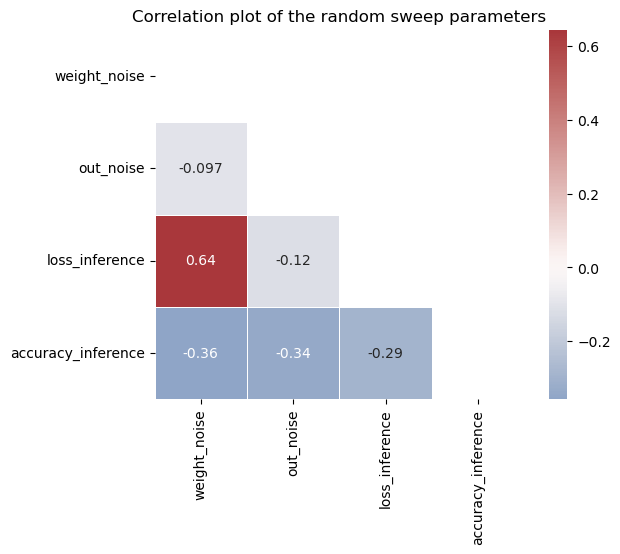

In [ ]:
fig, ax = plt.subplots()
corr = sweep_df[["weight_noise", "out_noise", "loss_inference", "accuracy_inference"]].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, square=True, linewidths=.5, center=0, annot=True, ax=ax, cmap=sns.color_palette("vlag", as_cmap=True))
plt.title("Correlation plot of the random sweep parameters")
plt.show()

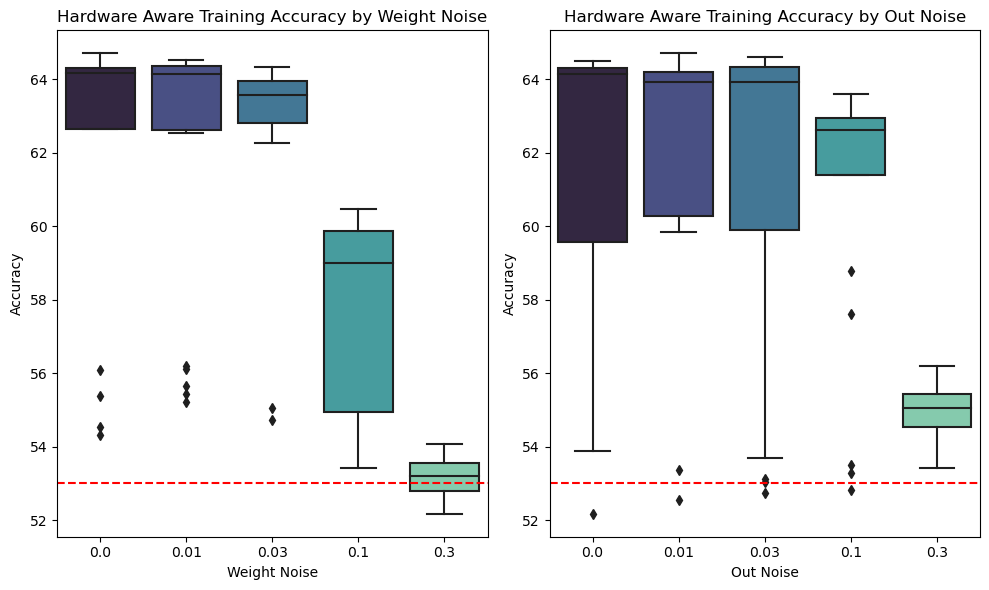

In [ ]:
keys, labels, orders = ["weight_noise", "out_noise"], ["Weight Noise", "Out Noise"], [[0.0,0.01,0.03,0.1,0.3]] * 2
fig, axs = plt.subplots(1,2,figsize=(10,6))
for ax, key, label, order in zip(axs.flatten(), keys, labels, orders):
    sns.boxplot(data=sweep_df[sweep_df.drift_time == 0], x=key, y="accuracy_inference", order=order, ax=ax, palette=sns.color_palette("mako", 5))
    ax.set_ylabel("Accuracy")
    ax.set_xlabel(label)
    ax.set_title("Hardware Aware Training Accuracy by " + label)
    ax.axhline(y=53, color="red", linestyle="--")
plt.tight_layout()
plt.show()

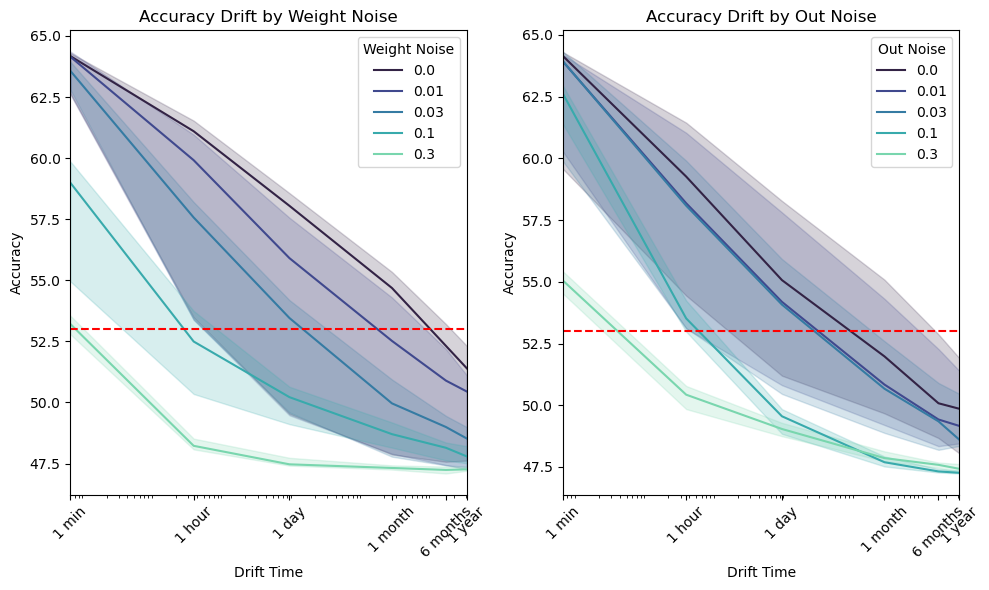

In [ ]:
keys, labels, orders, err = ["weight_noise", "out_noise"], ["Weight Noise", "Out Noise"], [[0.0,0.01,0.03,0.1,0.3]] * 2, [("pi", 50), ("pi", 50)]
fig, axs = plt.subplots(1,2,figsize=(10,6))
df = sweep_df.copy()
df.loc[df.drift_time==0, "drift_time"] = 60
for ax, key, label, order, err in zip(axs.flatten(), keys, labels, orders, err):
    sns.lineplot(data=df, x="drift_time", y="accuracy_inference", hue=key, hue_order=order, estimator="median", errorbar=err, ax=ax, palette=sns.color_palette("mako", 5))
    ax.set_xscale("log")
    ax.set_xticks([60] + t_inference_times)
    ax.set_xticklabels(["1 min"] + t_inference_labels, rotation=45)
    ax.axhline(y=53, color="red", linestyle="--")
    ax.legend(title=label)
    ax.set_xlim(60, t_inference_times[-1])
    ax.set_title("Accuracy Drift by "+ label)
    ax.set_xlabel("Drift Time")
    ax.set_ylabel("Accuracy")
plt.tight_layout()
plt.show()

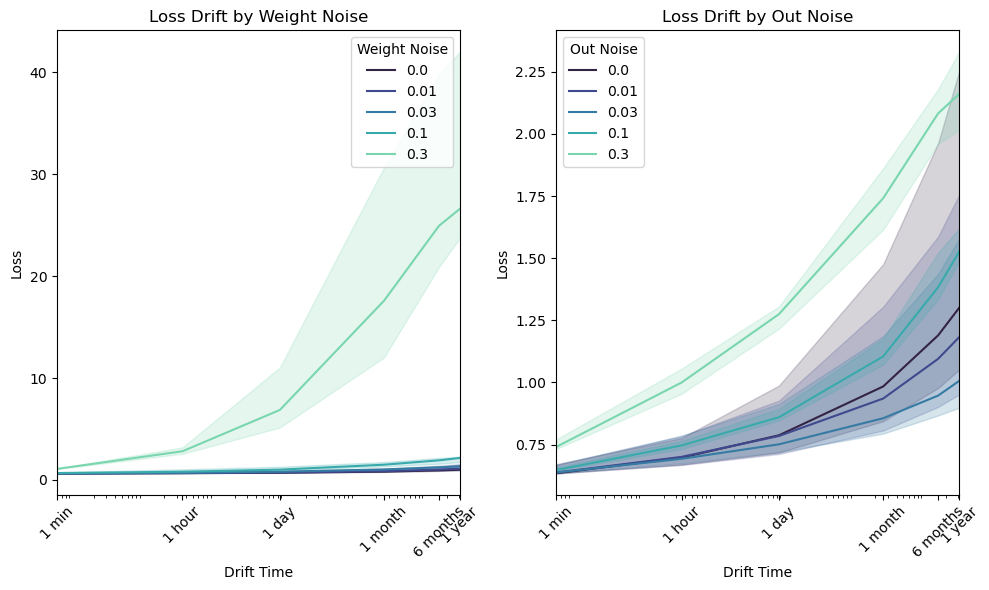

In [ ]:
keys, labels, orders, err = ["weight_noise", "out_noise"], ["Weight Noise", "Out Noise"], [[0.0,0.01,0.03,0.1,0.3]] * 2 , [("pi", 50), ("pi", 50)]
fig, axs = plt.subplots(1,2,figsize=(10,6))
df = sweep_df.copy()
df.loc[df.drift_time==0, "drift_time"] = 60
for ax, key, label, order, err in zip(axs.flatten(), keys, labels, orders, err):
    sns.lineplot(data=df, x="drift_time", y="loss_inference", hue=key, hue_order=order, estimator="median", errorbar=err, ax=ax, palette=sns.color_palette("mako", 5))
    ax.set_xscale("log")
    ax.set_xticks([60] + t_inference_times)
    ax.set_xticklabels(["1 min"] + t_inference_labels, rotation=45)
    ax.legend(title=label)
    ax.set_xlim(60, t_inference_times[-1])
    ax.set_title("Loss Drift by "+ label)
    ax.set_xlabel("Drift Time")
    ax.set_ylabel("Loss")
plt.tight_layout()
plt.show()